## Optimization:
- Change value of momentum 
- Batch normalization 
- Weight initialization 
- Number of parameters 
- Knowledge Distilation
- Dropout (Regularization)
- Tune hyperparameters 

Sources:
- https://towardsdatascience.com/how-to-optimize-a-deep-learning-model-2e9ff8a4c5de
- https://www.cs.toronto.edu/~lczhang/321/tut/tut06.html

### Parameters
- https://towardsdatascience.com/how-to-reduce-training-parameters-in-cnns-while-keeping-accuracy-99-a213034a9777

### Batch normalization 
- https://discuss.pytorch.org/t/loss-doesnt-decrease-while-training/83751/5
- https://androidkt.com/use-the-batchnorm-layer-in-pytorch/
- https://www.baeldung.com/cs/batch-normalization-cnn

### Weight Initialization 
- https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78


Hint from Nhan:
- "He" initialization 
- Validation (dont train)?
- Test validation set 

### Knowledge Distilation 
- https://josehoras.github.io/knowledge-distillation/
- https://github.com/haitongli/knowledge-distillation-pytorch
- https://het-shah.github.io/blog/2020/Knowledge-Distillation/
- https://towardsdatascience.com/build-powerful-lightweight-models-using-knowledge-distillation-618f69b569d9
- https://medium.com/analytics-vidhya/knowledge-distillation-for-object-detection-1-start-from-simple-classification-model-921e1b2bfed2

In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os 
import cv2
import pandas as pd 
import random 
import os, os.path
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchinfo import summary
import imutils


#use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#labels  
LABELS_DICT = {
    '0' : 0,
    '1' : 1,
    '2' : 2,
    '3' : 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    'plus' : 10,
    'minus' : 11,
    'slash' : 12,
    'dot' : 13,
    'w' : 14,
    'x' : 15,
    'y' : 16,
    'z' : 17,
    }

INV_LABELS_DICS = {v: k for k, v in LABELS_DICT.items()}

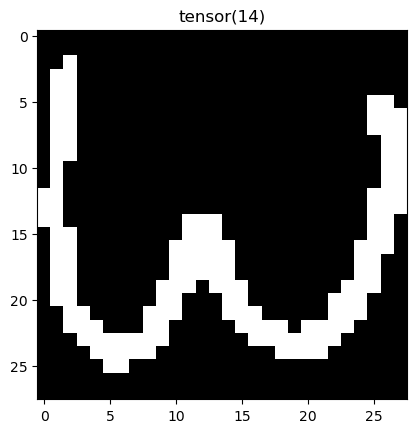

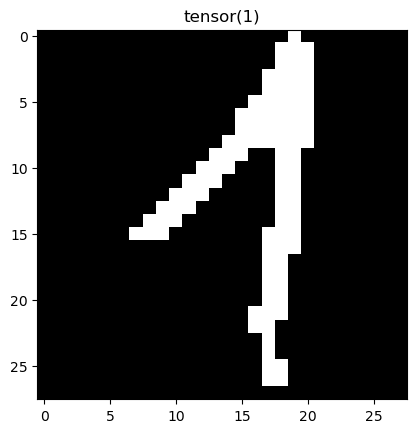

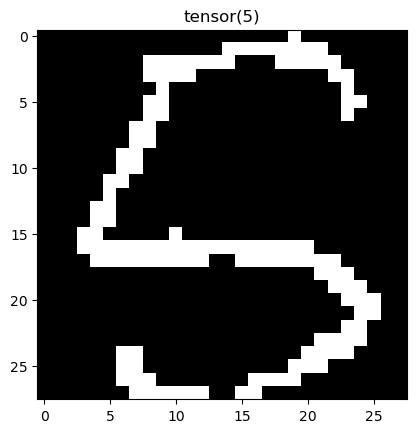

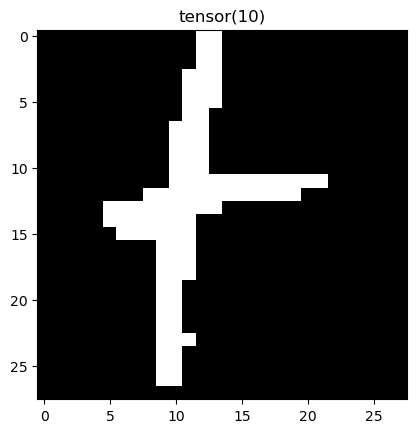

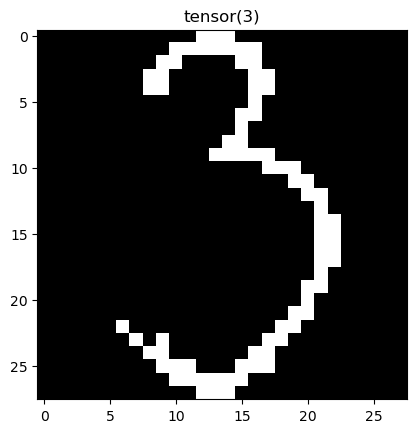

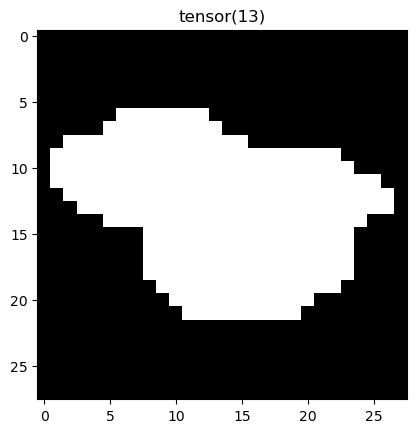

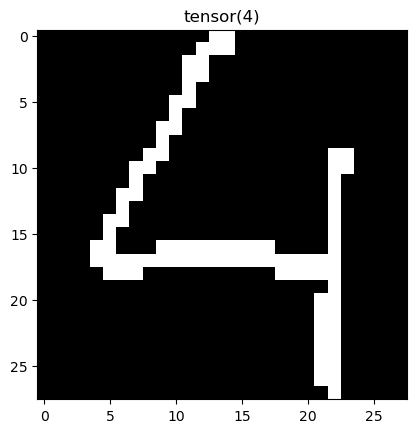

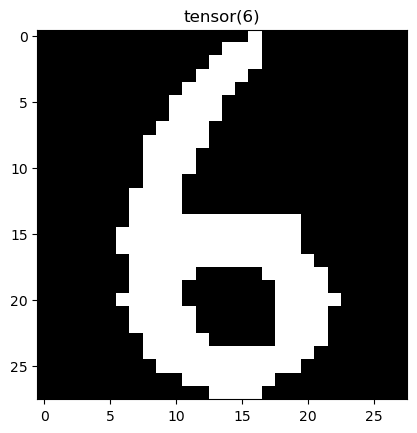

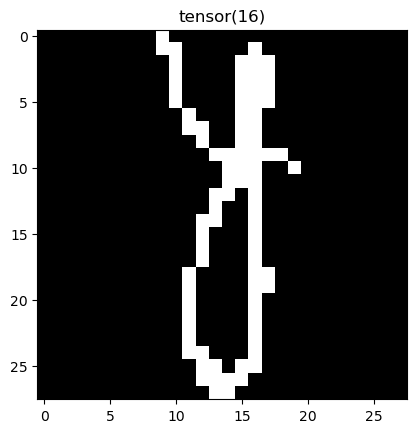

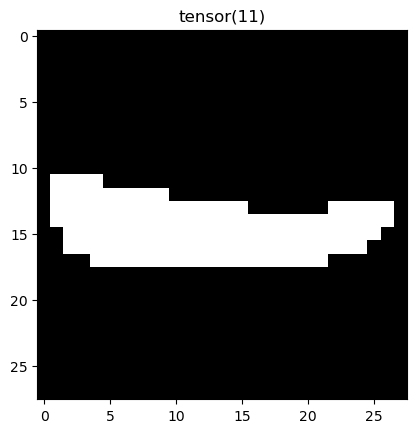

In [2]:
"""
CREATING CUSTOM DATASET
Data consist of: 
- Numbers from 1-9
- Operators: +, -, / and * 
- Letters: w, x, y, z

- Format of each image: <symbol-name>-<id>.png
- 1500 images of each type 
"""

class Digits(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    #function to resize image to same dimensions 
    def convert(self, img_path):
        image = cv2.imread(img_path)
        #image = cv2.resize(image, (32, 32))      
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converting from bgr to grayscale for faster computation 
        _ , image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

        if self.transform:
            image = self.transform(image) 

            """
            print("Normal:", torch.mean(image))
            print("Normal:", torch.std(image))
            print("Normal:",torch.var(image))
            """

            #normalizing tensor
            mean, std = torch.mean(image), torch.std(image)
            normalize = transforms.Normalize(mean, std)
            image = normalize(image)

            """       
            print("Normalised:", torch.mean(image))
            print("Normalised:", torch.std(image))
            print("Normalised:",torch.var(image))
            """
        return image

    #function to get image label
    def get_label(self, filename):
        label_name = filename.split("-")
        label = LABELS_DICT[label_name[0]]

        if self.target_transform:
            label = self.target_transform(label)
        
        return label

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        #getting image path
        filename = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, filename)
        
        #get image and corresponding label
        label = self.get_label(filename)
        image = self.convert(img_path)
        
        return image, label
    


#set up dataset
transform = transforms.Compose([transforms.ToTensor()]) #normalizing data
#target_transform = transforms.Compose([lambda x: torch.tensor([x]), 
#                                        lambda x: torch.nn.functional.one_hot(x, num_classes=len(LABELS_DICT))]) 

dataset = Digits("data/symbols/", transform=transform)

datasetSize = dataset.__len__()
batch_size = 2 

#split data: 80% training, 10% validation, 10% test
test_train_data, test_validation_data, test_test_data = random_split(dataset, [datasetSize - int(0.2 * datasetSize), int(0.1 * datasetSize), int(0.1 * datasetSize)])

#creating data loaders
test_trainloader = DataLoader(test_train_data, batch_size=batch_size, shuffle=True, num_workers=0)


"""
GETTING SOME IMAGES FROM DATASET 
"""
dataiter = iter(test_trainloader)
images, labels = dataiter.next()

#run through 3 batches
for i in range(5): #Run through 5 batches
    images, labels = dataiter.next()
    for image, label in zip(images, labels): # Run through all samples in a batch
        plt.figure()
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)), cmap="gray")
        plt.title(label)


In [3]:
"""
PREPARING DATA FOR TRAINING
"""
#normalizing data and one-hot encode
transform = transforms.Compose([transforms.ToTensor()])  

#create data
dataset = Digits("data/symbols/", transform=transform)
datasetSize = dataset.__len__()

batch_size = 128 

#split data: 80% training, 10% validation, 10% test
train_data, validation_data, test_data = random_split(dataset, [datasetSize - int(0.2 * datasetSize), int(0.1 * datasetSize), int(0.1 * datasetSize)])
#train_data, validation_data, test_data = random_split(dataset, [6500, 500, 20000])

#creating data loaders
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
validateloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

In [4]:
"""
KNOWLEDGE DISTILLIATION NETWORK
The basic idea behind Knowledge Distillation is that you define a Teacher (which can be a single model or an ensemble) and a 
Student ( Which is the lightweight model you want to use in production), 
then you train the Teacher on the target task and have the Student try to mimic the Teacher.

Steps:
1. Define and train a large network (teacher)
2. Define and train a small network (student)
3. Distillation training of the small netwrok using only the teacher's soft targets 
"""
class Teacher(nn.Module):
    def __init__(self, num_classes):
        super(Teacher, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same', bias=True)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding="same", bias=True)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding="same", bias=True)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.conv2_drop = nn.Dropout2d() #dropout (type of regularization) avoids overfitting
        self.fc1 = nn.Linear(64 * 3 * 3, 120)
        self.bn4 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn5 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, num_classes)        
    
    def forward(self, x):
        x = self.conv1(x)   #[batch size, 32, 28, 28]
        x = self.bn1(x)
        x = self.pool1(x)   #[batch size, 32, 14, 14]
        x = F.relu(x)
        x = self.conv2(x)   #[batch size, 32, 28, 28]
        x = self.bn2(x)
        x = self.pool2(x)   #[batch size, 32, 7, 7]
        x = F.relu(x)
        x = self.conv3(x)   #[batch size, 64, 7, 7]
        x = self.bn3(x)
        x = self.pool3(x)   #[batch size, 64, 3, 3]
        x = F.relu(x)
        x = self.flatten(x) #[batch size, 64 * 3 * 3]
        x = self.conv2_drop(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x



class Student(nn.Module):
    def __init__(self, num_classes):
        super(Student, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding='same', bias=True)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.conv2_drop = nn.Dropout2d() #dropout (type of regularization) avoids overfitting
        self.fc1 = nn.Linear(16 * 14 * 14, num_classes)

    def forward(self, x):
        x = self.conv1(x)   #[batch size, 32, 28, 28]
        x = self.bn1(x)
        x = self.pool1(x)   #[batch size, 32, 14, 14]
        x = F.relu(x)
        x = self.flatten(x) #[batch size, 32 * 14 * 14]
        x = self.conv2_drop(x)
        x = self.fc1(x)
        return x


#testing model 
testTeacherNetwork = Teacher(len(LABELS_DICT)).to(device)
print(summary(testTeacherNetwork, (1, 1, 28, 28)))

testStudentNetwork = Student(len(LABELS_DICT)).to(device)
print(summary(testStudentNetwork, (1, 1, 28, 28)))


"""
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

print(len(example_data))
print(example_data.shape)
"""

Layer (type:depth-idx)                   Output Shape              Param #
Teacher                                  [1, 18]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 32, 14, 14]           9,248
├─BatchNorm2d: 1-5                       [1, 32, 14, 14]           64
├─MaxPool2d: 1-6                         [1, 32, 7, 7]             --
├─Conv2d: 1-7                            [1, 64, 7, 7]             18,496
├─BatchNorm2d: 1-8                       [1, 64, 7, 7]             128
├─MaxPool2d: 1-9                         [1, 64, 3, 3]             --
├─Flatten: 1-10                          [1, 576]                  --
├─Dropout2d: 1-11                        [1, 576]                  --
├─Linear: 1-12                           [1, 120]                  69,240
├─

c:\Users\emilh\anaconda3\envs\dl\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


'\nexamples = enumerate(trainloader)\nbatch_idx, (example_data, example_targets) = next(examples)\n\nprint(len(example_data))\nprint(example_data.shape)\n'

In [ ]:
"""
TRAINING FOR TEACHER
"""
def 

"""
TRAINING FOR STUDENT
"""


In [5]:
"""
TRAINING METHOD
"""
#lists to hold accuracy and loss - used for plotting 
training_losses = []
training_accuracy = []

def train(network, trainloader, optimizer, criterion, device):
    #variables accuracy and loss 
    size, batch_size = 0, 0
    training_correct, correct = 0, 0 

    #setting network to training mode 
    network.to(device)
    network.train()
    
    #training the model
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        #calculate predictions and loss
        output = network(data)
        loss = criterion(output, target)

        #backpropagate
        optimizer.zero_grad()   #1. sets gradients to zero
        loss.backward()         #2. compute new gradients using back propagation
        optimizer.step()        #3. update parameters with new gradients 

        #computing accuracy 
        correct = (output.argmax(1) == target).type(torch.float).sum().item()
        training_correct += correct
        batch_size = len(data)

        #storing loss 
        training_losses.append(loss.item())
        training_accuracy.append(correct / batch_size)

        #updating size
        size += batch_size
        
        #print out loss data
        if(batch_idx % 100 == 0):
            print("[{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(batch_idx * len(data),
                                                            len(trainloader.dataset),
                                                            100. * batch_idx / len(trainloader), 
                                                            loss.item()))
    #save internal state
    torch.save(network.state_dict(), "model.pth")
    torch.save(optimizer.state_dict(), "optimizer.pth")

    #print training accuracy 
    training_correct = training_correct / size 

    print(f"Training accuracy: {(100 * training_correct):>0.1f}%")
    

In [6]:
"""
VALIDATION METHOD
"""
#lists to hold accuracy and loss - used for plotting 
validate_losses = []
validate_accuracy = []


def validate(network, validationloader, criterion, device):
    #variables
    size, batch_size = 0, 0
    validation_loss, loss = 0, 0
    validation_correct, correct = 0, 0

    num_batches = len(validationloader)

    #set network to testing mode
    network.to(device)
    network.eval()

    #validating the model 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(validationloader):
            data, target = data.to(device), target.to(device)

            #getting batch size 
            batch_size = len(data)

            #predicting the output 
            output = network(data)

            #loss 
            loss = criterion(output, target)
            validation_loss += loss.item()
            validate_losses.append(loss.item())

            #accuracy
            correct = (output.argmax(1) == target).type(torch.float).sum().item()
            validation_correct += correct
            validate_accuracy.append(correct / batch_size)

            #updating size
            size += batch_size
        
    #calculate loss 
    validation_loss = validation_loss / num_batches

    #calculate accuracy   
    validation_correct = validation_correct / size

    #printing output of validation  
    print(f"Validation set: \n Accuracy: {(100 * validation_correct):>0.1f}%, Average loss: {validation_loss:>8f} \n")

In [8]:
"""
TRAINING FOR KNOWLEDGE DISTILLATION 
"""
epochs = 2
num_classes = len(LABELS_DICT)
learning_rate = 0.01 
momentum = 0.5

student = Student(num_classes=num_classes)
teacher = Teacher(num_classes=num_classes)

optimizer_student = optim.SGD(student.parameters(), lr=learning_rate, momentum=momentum)
optimizer_teacher = optim.SGD(teacher.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.functional.cross_entropy   #default loss function for multi-class classifications problems         


#training and validating the teacher
for iEpoch in range(epochs): 
    print(f"Epoch {iEpoch + 1}\n--------------------")

    train(teacher, trainloader, optimizer, criterion, device)
    validate(teacher, validateloader, criterion, device)

"""
#training and validating the student
for iEpoch in range(epochs): 
    print(f"Epoch {iEpoch + 1}\n--------------------")

    train(student, trainloader, optimizer, criterion, device)
    validate(student, validateloader, criterion, device)

"""

Epoch 1
--------------------


c:\Users\emilh\anaconda3\envs\dl\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[0/21600 (0%)]	Loss: 2.945903
[6400/21600 (30%)]	Loss: 1.924645
[12800/21600 (59%)]	Loss: 1.092626
[19200/21600 (89%)]	Loss: 0.700013
Training accuracy: 64.9%
Validation set: 
 Accuracy: 91.4%, Average loss: 0.518750 

Epoch 2
--------------------
[0/21600 (0%)]	Loss: 0.636300
[6400/21600 (30%)]	Loss: 0.554955
[12800/21600 (59%)]	Loss: 0.434617
[19200/21600 (89%)]	Loss: 0.318172
Training accuracy: 90.3%
Validation set: 
 Accuracy: 95.7%, Average loss: 0.196542 



'\n#training and validating the student\nfor iEpoch in range(epochs): \n    print(f"Epoch {iEpoch + 1}\n--------------------")\n\n    train(student, trainloader, optimizer, criterion, device)\n    validate(student, validateloader, criterion, device)\n\n'

In [12]:
"""
CUSTOM LOSS FUNCTION
"""
softmax_op = nn.Softmax(dim=1)
mseloss_fn = nn.MSELoss()

def criterion_kd(scores, targets, temperature=5):
    #getting predictions 
    soft_predictions = softmax_op(scores / temperature)
    soft_targets = softmax_op(targets / temperature)

    loss = mseloss_fn(soft_predictions, soft_targets)

    return loss 

"""
KD TRAINING 
"""
kd_train_accuracy = []
kd_train_loss = []

def kd_train(student_network, teacher_network, trainloader, optimizer, device):

    size, batch_size = 0, 0
    training_correct, correct = 0, 0
    student_network.to(device), teacher_network.to(device)
    student_network.train()
    teacher_network.train()


    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)

        scores = student_network(data)
        targets = teacher_network(data)

        loss = criterion_kd(scores, targets)

        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #computing accuracy 
        correct = (scores.argmax(1) == target).type(torch.float).sum().item()
        training_correct += correct
        batch_size = len(data)

        #storing loss 
        kd_train_loss.append(loss.item())
        kd_train_accuracy.append(correct / batch_size)

        #updating size
        size += batch_size
        
        #print out loss data
        if(batch_idx % 100 == 0):
            print("[{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(batch_idx * len(data),
                                                            len(trainloader.dataset),
                                                            100. * batch_idx / len(trainloader), 
                                                            loss.item()))
    #save internal state
    torch.save(student_network.state_dict(), "model.pth")
    torch.save(optimizer.state_dict(), "optimizer.pth")

    #print training accuracy 
    training_correct = training_correct / size 

    print(f"Training accuracy: {(100 * training_correct):>0.1f}%")


"""
KD VALIDATION 
"""
optimizer_student = optim.SGD(student.parameters(), lr=learning_rate, momentum=momentum)


"""
TRAINING THE STUDENT
"""
new_student = Student(num_classes=num_classes)

for iEpoch in range(epochs):
    kd_train(new_student, teacher, trainloader, optimizer_student, device) 

[0/21600 (0%)]	Loss: 0.001108
[6400/21600 (30%)]	Loss: 0.001103
[12800/21600 (59%)]	Loss: 0.001067
[19200/21600 (89%)]	Loss: 0.001094
Training accuracy: 4.5%
[0/21600 (0%)]	Loss: 0.001029
[6400/21600 (30%)]	Loss: 0.001029
[12800/21600 (59%)]	Loss: 0.000966
[19200/21600 (89%)]	Loss: 0.001017
Training accuracy: 4.4%


ValueError: x and y must have same first dimension, but have shapes (676,) and (3260,)

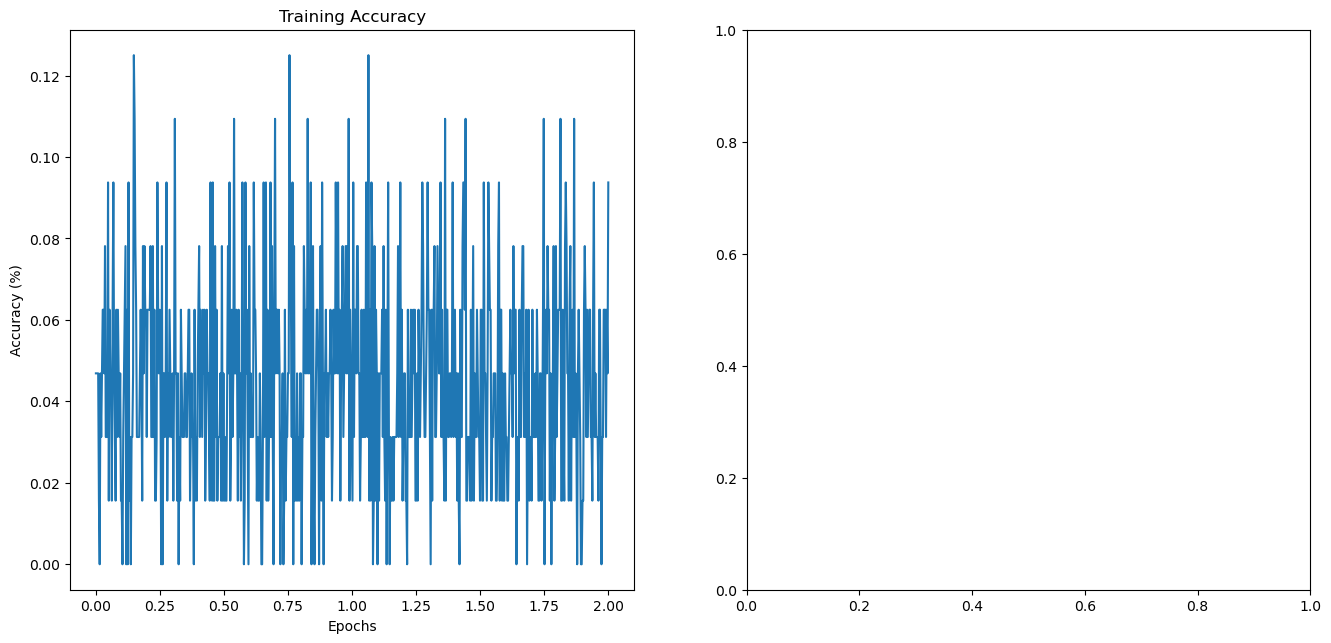

In [14]:
"""
PLOTTING RESULTS
"""
figure = plt.figure(figsize=(16, 16)) 
epochs_training = np.linspace(0, epochs, len(kd_train_accuracy))
epochs_validation = np.linspace(0, epochs, len(validate_accuracy))


#training accuracy
figure.add_subplot(2, 2, 1)
plt.plot(epochs_training, kd_train_accuracy)
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

#training loss
figure.add_subplot(2, 2, 2)
plt.plot(epochs_training, training_losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")


#validation accuracy 
figure.add_subplot(2, 2, 3)
plt.plot(epochs_validation, validate_accuracy)
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")


#validation loss
figure.add_subplot(2, 2, 4)
plt.plot(epochs_validation, validate_losses)
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation loss")


## Notes

#### Loss 
- Does validation loss converge? If not, adjust number of epochs or learning rate / optimizer
- Is validation loss too high? Consider more regularization if so.

### Grid search
- A common way to scan for good hyperparameter values is a ‘grid search’, in which multiple parameters are varied simultaneously

### Batch
-  Generally, small batch sizes will need fewer epochs to converge.

## Questions 
- When/How to initialize weights? (torch.nn.init.xavier_uniform(conv1.weight)
- Where to apply batch normalization?
- Batch size & number of epochs? 
- Remove layers
- Should we go after more accuracy? 
- Downscale? 